## 1. Prepare data

### 1.1 Load testing data

In [ ]:
using TorusEvol
using Distributions
using Turing
using BioStructures
using DynamicPPL
using LinearAlgebra
using LogExpFunctions 
using Plots, StatsPlots
using Random

Random.seed!(1000001)
Turing.setprogress!(true)

# The three globins of interest
# Goal: obtain a triple alignment and branch lengths to common ancestor
alphaglobin = from_pdb("1A3N", "A"); Y = data(alphaglobin)
myoglobin = from_pdb("1MBN", "A"); Z = data(myoglobin)
neuroglobin = from_pdb("1OJ6", "A"); W = data(neuroglobin)
render(alphaglobin, myoglobin, neuroglobin)

In [ ]:
row1 = "-MERPEPELIRQSWRAVSRSPLEHGTVLFARLFALEPDLLPLFQYNGRQFSSPEDSLSSPEFLDHIRKVMLVIDAAVTNVEDLSSLEEYLASLGRKH-RAVGVKLSSFSTVGESLLYMLEKSLGPAFTPATRAAWSQLYGAVVQAMSR-----GWDGE"
row2 = "VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQ-------VKGHGKKVADALTNAVAHVDDMPN---ALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR-------"
row3 = "VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEM-KASEDLKKHGVTVLTALGAILKKKGHHEA---ELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG-"
function to10(a)
    if a == "-"
        return 0
    else 
        return 1
    end
end
clustal_M_YZW = Alignment(vcat(to10.(row2)', to10.(row3)', to10.(row1)'))

### 1.2 Load training data

In [2]:
globins=[from_pdb("1A3N", "B"), from_pdb("1UMO", "A"), 
         from_pdb("1I3D", "A"), from_pdb("1A9W", "A"),
         from_pdb("3VRF", "A"), from_pdb("2W31", "A")]
gdata = data.(globins)

train_data = [(gdata[1], gdata[2]),
              (gdata[3], gdata[4]),
              (gdata[5], gdata[6])]

[ Info: File exists: 1A3N
[ Info: File exists: 1UMO
[ Info: File exists: 1I3D
[ Info: File exists: 1A9W
[ Info: File exists: 3VRF
[ Info: File exists: 2W31


3-element Vector{Tuple{ObservedChain, ObservedChain}}:
 (ObservedChain(
num sites: 145
num coords: 2
), ObservedChain(
num sites: 154
num coords: 2
))
 (ObservedChain(
num sites: 146
num coords: 2
), ObservedChain(
num sites: 141
num coords: 2
))
 (ObservedChain(
num sites: 141
num coords: 2
), ObservedChain(
num sites: 152
num coords: 2
))

## 2. Parameter Inference Bayesian Model

### 2.1 Probabilistic Model

In [3]:
using Memoization 

@memoize get_αs(pairs) = get_α.(Ref(TKF92([1.0], 0.2, 0.3, 0.4)), pairs)
@memoize get_Bs(pairs) = get_B.(pairs);

@model function pair_param_inference(pairs, α, B)
    N = length(pairs)
    # ____________________________________________________________________________________________________
    # Step 1 - Sample prior parameters
    
    # Time parameter for each pair
    t ~ filldist(Exponential(1.0), N)
    
    # Alignment parameters
    @submodel prefix="τ" Λ = tkf92_prior()
    # Dihedral parameters 
    @submodel prefix="Θ" Ξ = jwndiff_prior()
    # Check parameter validity 
    if any(t .≤ 0) || any(isnan.(Ξ)) || any(isnan.(Λ))
        Turing.@addlogprob! -Inf; return
    end
    
    # ____________________________________________________________________________________________________
    # Step 2 - Construct processes 
    
    # Substitution Process - no parameters for simplicity, use fully empirical model
    S = WAG_SubstitutionProcess()
    # Dihedral Process
    Θ = JumpingWrappedDiffusion(Ξ...)
    # Joint sequence-structure site level process with one regime
    ξ = ProductProcess(S, Θ)
    
    # ____________________________________________________________________________________________________
    # Step 3 - Observe each pair X, Y by proxy of their joint probability, marginalising over alignments
    for i ∈ 1:N
        X, Y = pairs[i]
        Γ = ChainJointDistribution(ξ, TKF92([t[i]], Λ...))
            
        # (X, Y) ~ ChainJointDistribution(ξ, τ)
        
        fulljointlogpdf!(B[i], ξ, t[i], X, Y)
        Turing.@addlogprob! logpdfαB!(α[i], B[i], Γ, (X, Y))
    end
        
    return t, Λ, Ξ
end

pair_param_inference (generic function with 2 methods)

### 2.2 Run the model

In [8]:
model = pair_param_inference(train_data, get_αs(train_data), get_Bs(train_data));


sampler = Gibbs(t_samplers..., τ_samplers..., Θ_samplers...)
    
num_samples = 500
num_chains = 3

chain = sample(model, sampler, MCMCThreads(), num_samples, num_chains)

Chains MCMC chain (500×15×3 Array{Float64, 3}):

Iterations        = 1:1:500
Number of chains  = 3
Samples per chain = 500
Wall duration     = 14488.24 seconds
Compute duration  = 42897.16 seconds
parameters        = t[1], t[2], t[3], τ.λμ[1], τ.λμ[2], τ.r, Θ.μ[1], Θ.μ[2], Θ.σ²[1], Θ.σ²[2], Θ.α[1], Θ.α[2], Θ.γ, Θ.α_corr
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        t[1]    0.8114    0.3389    0.1538     4.8703    16.6599    1.6854     ⋯
        t[2]    0.3193    0.2051    0.0444     9.4815    15.6072    1.3629     ⋯
        t[3]    1.4031    0.3745    0.0989    14.0765    13.1752    1.3272     ⋯
     τ.λμ[1]    0.2595    0.0984    0.0403     5.9772     3.4301    2.5072     ⋯
     τ.λμ[2]    0.2756    0.1092    0.0459     5.6972     3.3266    2.4701     ⋯
         τ.r    0.6847    0.0860    0.0338     6.6676    85.5123   

### 2.3 Diagnose convergence

In [24]:
chain[200:500, :, :]

Chains MCMC chain (301×15×3 Array{Float64, 3}):

Iterations        = 200:1:500
Number of chains  = 3
Samples per chain = 301
Wall duration     = 14488.24 seconds
Compute duration  = 42897.16 seconds
parameters        = t[1], t[2], t[3], τ.λμ[1], τ.λμ[2], τ.r, Θ.μ[1], Θ.μ[2], Θ.σ²[1], Θ.σ²[2], Θ.α[1], Θ.α[2], Θ.γ, Θ.α_corr
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        t[1]    0.6812    0.2024    0.1000     3.8376     7.9872    2.4132     ⋯
        t[2]    0.2877    0.0758    0.0403     3.8538        NaN    2.3347     ⋯
        t[3]    1.4462    0.1931    0.0715     5.7555        NaN    1.5202     ⋯
     τ.λμ[1]    0.2587    0.0699    0.0389     3.6025     3.0822    2.6578     ⋯
     τ.λμ[2]    0.2683    0.0762    0.0422     3.6010     3.0822    2.6588     ⋯
         τ.r    0.6631    0.0733    0.0284     6.6647    78.1411 

In [10]:
savefig("globins pairs convergence plots.svg")

"C:\\Users\\stefa\\Dropbox\\Jotun Hein - Part C Projects\\Manolache\\Code\\TorusEvol\\globins pairs convergence plots.svg"

In [48]:
gelmandiag(chain)

Gelman, Rubin, and Brooks diagnostic
  parameters      psrf    psrfci 
      Symbol   Float64   Float64 

        t[1]    1.5871    2.6841
        t[2]    1.1332    1.3503
        t[3]    1.2024    1.5871
     τ.λμ[1]    1.9118    5.2021
     τ.λμ[2]    2.0055    7.4905
         τ.r    1.4975    2.2771
      Θ.μ[1]    1.1921    1.6034
      Θ.μ[2]    1.3951    2.7491
     Θ.σ²[1]    1.3208    2.3171
     Θ.σ²[2]    1.2873    1.7977
      Θ.α[1]    1.6213    4.3347
      Θ.α[2]    2.2051    5.4284
         Θ.γ    1.1358    1.2404
    Θ.α_corr    1.1638    1.4155


# 3. Alignment & Branch lengths

### 3.1 Set parameters

In [4]:
Λ = (0.2599, 0.2656, 0.678)
(λ, μ, r) = Λ
mean_fragment_length = 1 /(1-r)
mean_seq_length = 1/(1 - λ/μ)
mean_fragment_length*mean_seq_length

144.70960008717455

In [5]:
S = WAG_SubstitutionProcess()
μ_𝜙=-1.2224; μ_𝜓=-0.3769; σ_𝜙=sqrt(0.4017); σ_𝜓=sqrt(0.2584); α_𝜙=1.3537; α_𝜓=0.2157; α_corr=0.6902; γ=0.0034
α_cov = α_corr * sqrt(α_𝜙 * α_𝜓)
Θ = JumpingWrappedDiffusion(μ_𝜙, μ_𝜓, σ_𝜙, σ_𝜓, α_𝜙, α_𝜓, α_cov, γ)
ξ = ProductProcess(S, Θ);

### 3.2 Probabilistic Model

In [7]:
@model function triple_alignment_sampler(Y, Z, W, Λ, ξ; max_N_X=200)
    N_Y = num_sites(Y); N_Z = num_sites(Z); N_W = num_sites(W)
    # ____________________________________________________________________________________________________
    # Step 1 - Sample prior parameters
    
    # Time parameters
    t ~ filldist(Exponential(1.0), 3)
    t_Y=t[1]; t_Z=t[2]; t_W=t[3]
    
    # Check parameter validity 
    if t_Y ≤ 0 || t_Z ≤ 0 || t_W ≤ 0
        Turing.@addlogprob! -Inf; return
    end
    
    # ____________________________________________________________________________________________________
    # Step 2 - Observe data and simultaneously construct alignment 
    
    # First, observe Y and Z and sample a triple alignment of X, Y and Z 
    τ_XYZ = TKF92([t_Y, t_Z], Λ...; known_ancestor=false)
    α_YZ = get_α(τ_XYZ, [Y, Z])
    Γ_YZ = ChainJointDistribution(ξ, τ_XYZ)
    # (Y, Z) ~ ChainJointDistribution(ξ, τ_XYZ)
    Turing.@addlogprob! logpdfα!(α_YZ, Γ_YZ, (Y, Z))
    
    M_XYZ = tzeros(Int, max_N_X + N_Y + N_Z)
    M_XYZ ~ ConditionedAlignmentDistribution(τ_XYZ, α_YZ; max_length=max_N_X + N_Y + N_Z)
    
    # Construct X, the hidden ancestor chain, given alignment M_XYZ and data Y, Z
    X = hiddenchain_from_alignment(Y, Z, t_Y, t_Z, Alignment(M_XYZ, τ_XYZ), ξ); N_X = num_sites(X)
    
    # Finally, observe W given X and sample alignment of X and W
    τ_XW = TKF92([t_W], Λ...; known_ancestor=true)
    α_XW = get_α(τ_XW, [X, W])
    Γ_XW = ChainTransitionDistribution(ξ, τ_XW, X)
    # W ~ ChainTransitionDistribution(ξ, τ_XW, X)
    Turing.@addlogprob! logpdfα!(α_XW, Γ_XW, W)
    M_XW = tzeros(Int, N_X + N_W)
    M_XW ~ ConditionedAlignmentDistribution(τ_XW, α_XW; max_length=N_X + N_W)
    
    #full_alignment = combine(1, Alignment(M_XYZ, [1, 2, 3], τ_XYZ), Alignment(M_XW, [1, 4], τ_XW))
    #print("times: XY: $t_Y, XZ: $t_Z, XW: $t_W \n")
    #show_filled_alignment(full_alignment, fill('#', N_X), id_to_aa.(data(Y)[1]), id_to_aa.(data(Z)[1]), id_to_aa.(data(W)[1]))
    #return full_alignment
end;

### 3.3.0 Experiment with different coordinate choices

### 3.3.1 Both substitution and diffusion

In [24]:
function mcmcchain_to_alignments(chain)
    d = collect(get(chain, :M_XYZ).M_XYZ)
    len = length(d)
    mat = vcat([(d[i].data)' for i ∈ 1:len]...)
    mat[ismissing.(mat)] .= 0.0
    mat = Int.(mat)
    τ_XYZ = TKF92([1.0, 1.0], Λ...; known_ancestor=false)
    M_XYZs = [Alignment(vec(mat[:, i]), [1, 2, 3], τ_XYZ) for i ∈ 1:size(mat,2)]
    
    d = collect(get(chain, :M_XW).M_XW)
    len = length(d)
    mat = vcat([(d[i].data)' for i ∈ 1:len]...)
    mat[ismissing.(mat)] .= 0.0
    mat = Int.(mat)
    τ_XW = TKF92([1.0], Λ...; known_ancestor=true)
    M_XWs = [Alignment(vec(mat[:, i]), [1, 4], τ_XW) for i ∈ 1:size(mat,2)]
    
    M_XYZWs = combine.(Ref(1), M_XYZs, M_XWs)
    M_YZWs = subalignment.(M_XYZWs, Ref([2, 3, 4]))
    M_YZWs = Alignment.(data.(M_YZWs), Ref([1, 2, 3]) )
    M_YZWs
end


mcmcchain_to_alignments (generic function with 1 method)

In [31]:
model = triple_alignment_sampler(Y, Z, W, Λ, ξ; max_N_X=400)
num_samples = 500
chain = sample(model, IS(), num_samples);
sub_diff_alignments = mcmcchain_to_alignments(chain);
@info covariance_sum(sub_diff_alignments)

Sampling: 100%|█████████████████████████████████████████| Time: 0:25:11
[ Info: 984906.8937875752


### 3.3.2 Only substitution

In [32]:
Y_sub = slice(Y, :, [1]); Z_sub = slice(Z, :, [1]); W_sub = slice(W, :, [1]); ξ_sub = ProductProcess(S)
model = triple_alignment_sampler(Y_sub, Z_sub, W_sub, Λ, ξ_sub; max_N_X=400)
num_samples = 500
chain = sample(model, IS(), num_samples)
sub_alignments = mcmcchain_to_alignments(chain)
@info covariance_sum(sub_alignments)

Sampling: 100%|█████████████████████████████████████████| Time: 0:17:15
[ Info: 1.7883454589178357e6


### 3.3.3 Only diffusion

In [ ]:
Y_diff = slice(Y, :, [2]); Z_diff = slice(Z, :, [2]); W_diff = slice(W, :, [2]); ξ_diff = ProductProcess(Θ)
model = triple_alignment_sampler(Y_diff, Z_diff, W_diff, Λ, ξ_diff; max_N_X=400)
num_samples = 500
chain = sample(model, IS(), num_samples)
diff_alignments = mcmcchain_to_alignments(chain)
@info covariance_sum(diff_alignments)

Sampling:  70%|█████████████████████████████            |  ETA: 0:07:04

### 3.3.4 Comparing their covariances

In [ ]:
@info covariance_sum(sub_diff_alignments)
@info covariance_sum(sub_alignments)
@info covariance_sum(diff_alignments)

### 3.3.5 Compare with clustal alignment

In [ ]:
function sample_variance(v::AbstractVector{Alignment}, x::Alignment)
    N = length(v)
    res = 0
    for i ∈ 1:N
        res += distance(v[i], x)
    end
    return res / (N-1)
end

In [ ]:
@info sample_variance(sub_diff_alignments, clustal_M_YZW)
@info sample_variance(sub_alignments, clustal_M_YZW)
@info sample_variance(diff_alignments, clustal_M_YZW)

### 3.3.6 miscellaneous 

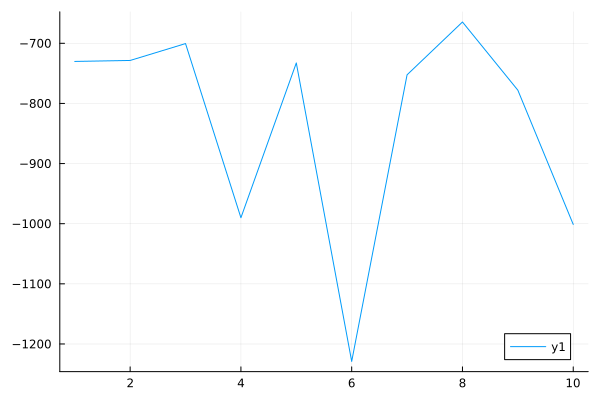

In [23]:
lps = vec(collect(MCMCChains.group(chain, :lp).value))
plot(lps)

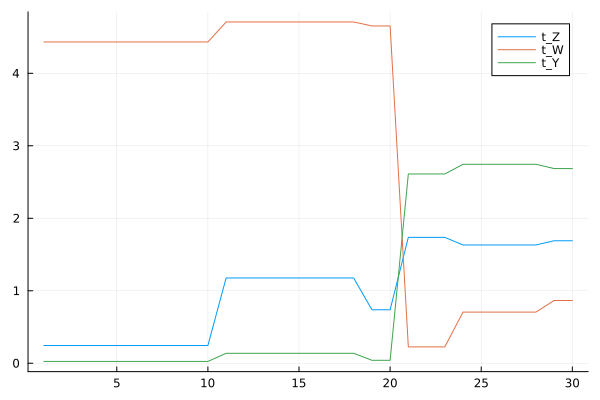

In [34]:
t_Y = vec(collect(get(chain, :t).t[1]))
t_Z = vec(collect(get(chain, :t).t[2]))
t_W = vec(collect(get(chain, :t).t[3]))
plot(t_Z, label="t_Z")
plot!(t_W, label="t_W")
plot!(t_Y, label="t_Y")

# 4. Sample trajectory

In [26]:
scale = 100
t = 1.0
λ, μ, r = Λ
τ = TKF92([t], λ, μ, r)
Γ = ChainJointDistribution(ξ, τ)

α_YZ = get_α(τ, (Y, Z))
lp = logpdfα!(α_YZ, Γ, (Y, Z)); print(lp)
M_YZ = Alignment(rand(ConditionedAlignmentDistribution(τ, α_YZ; max_length=num_sites(Y) + num_sites(Z))), τ)
print(M_YZ)

-1329.9780347237333
#-###################---#####################---##########--###############
-#################---#############################-----#####------#########

#################----###--#################################################
###########----######-#-#################################################--

##############----####
--#---#############---




In [31]:
Turing.setprogress!(false)
traj, M = trajectory_reconstruction(M_YZ, Y, Z, ξ, 0.01, Λ; levels=3)
polys = write_trajectory(traj, M, alphaglobin, myoglobin, "traj")

[ Info: [Turing]: progress logging is disabled globally
[ Info: [AdvancedVI]: global PROGRESS is set as false
[ Info: reconstructing ancestor...
[ Info: reconstructing ancestor...
[ Info: reconstructing ancestor...
[ Info: reconstructing ancestor...
[ Info: reconstructing ancestor...
[ Info: reconstructing ancestor...
[ Info: reconstructing ancestor...


9-element Vector{Polypeptide}:
 Polypeptide from chain A of protein 1MBN.pdb with 153 sites
and internal coordinates given by: ["aminoacid", "ramachadran angles"]
 Polypeptide from chain X of protein  with 152 sites
and internal coordinates given by: ["aminoacid", "ramachadran angles"]
 Polypeptide from chain X of protein  with 151 sites
and internal coordinates given by: ["aminoacid", "ramachadran angles"]
 Polypeptide from chain X of protein  with 145 sites
and internal coordinates given by: ["aminoacid", "ramachadran angles"]
 Polypeptide from chain X of protein  with 141 sites
and internal coordinates given by: ["aminoacid", "ramachadran angles"]
 Polypeptide from chain X of protein  with 140 sites
and internal coordinates given by: ["aminoacid", "ramachadran angles"]
 Polypeptide from chain X of protein  with 142 sites
and internal coordinates given by: ["aminoacid", "ramachadran angles"]
 Polypeptide from chain X of protein  with 142 sites
and internal coordinates given by: ["ami

In [64]:
MM = subalignment(M, [9, 7, 5, 3, 1])
aaa(chain) = id_to_aa.(Int.(chain.data[1]))
bbb(chain) = fill('#', length(chain.data[1]))
contents = vec.([aaa(traj[9]), bbb(traj[7]),bbb(traj[5]), bbb(traj[3]), aaa(traj[1])])
show_filled_alignment(MM, contents...)


-VLSPADKTNVKAAWGKV---GAHAGEYGAEALERMFLSFPTTKTYFPHF-----DLSHG------SAQVKGHGK
-#################---#############################-----#####------#########
-#################------##########################-----#####------#########
--################------###################################################
V-LSEGEWQLVLHVWAKVEAD---VAGHGQDILIRLFKSHPETLE---KFDRFKHLKT--EAEMKASEDLKKHGV

KVADALTNAVA----HVDDMP-N-ALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDK--
#################----##-#################################################--
#################----###--###############################################--
#################----###--#################################################
TVLTALGAILKKKGHHE----AEL--KPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKAL

--F---LASVSTVLTSKYR---
--#---#############---
--#################---
##############----#---
ELFRKDIAAKYKEL----GYQG

